In [2]:
!pip install catboost
import statistics
# # Install a pip package in the current Jupyter kernel
# import sys
# !{sys.executable} -m pip install numpy
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE, SVMSMOTE
from sklearn import svm
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge, LinearRegression
from sklearn.metrics import f1_score, accuracy_score, classification_report, roc_auc_score, roc_curve, confusion_matrix
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV, train_test_split, cross_val_score, \
    ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from tqdm import tqdm
import xgboost as xgb
from matplotlib import pyplot
from catboost import CatBoostClassifier
import lightgbm as lgb
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", message="the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'")

     |████████████████████████████████| 67.3MB 43kB/s 


In [3]:
def fill_missing_values(df_to_fill):
    df_to_fill.dropna(how='all')
    df_to_fill = df_to_fill.apply(lambda x: x.fillna(x.mean()),axis=0)
    print(df_to_fill)
    return df_to_fill

In [4]:
def pre_processing(df_in):
    preproc_df=df_in
    print("Start Pre-processing")
    to_drop = ['Patient ID',
               'Patient age quantile',
               'Patient addmited to regular ward (1=yes, 0=no)',
               'Patient addmited to semi-intensive unit (1=yes, 0=no)',
               'Patient addmited to intensive care unit (1=yes, 0=no)',
               'Urine - Esterase',
               'Urine - pH',
               'Urine - Hemoglobin',
               'Urine - Bile pigments',
               'Urine - Ketone Bodies',
               'Urine - Nitrite',
               'Urine - Density',
               'Urine - Urobilinogen',
               'Urine - Protein',
               'Urine - Sugar',
               'Urine - Leukocytes',
               'Urine - Crystals',
               'Urine - Red blood cells',
               'Urine - Hyaline cylinders',
               'Urine - Granular cylinders',
               'Urine - Yeasts',
               'Urine - Color',
               'Influenza A',
               'Influenza B',
               'Parainfluenza 1',
               'Parainfluenza 3',
               'Parainfluenza 2',
               'Parainfluenza 4',
               'Respiratory Syncytial Virus',
               'CoronavirusNL63',
               'Coronavirus HKU1',
               'Coronavirus229E',
               'CoronavirusOC43',
               'Inf A H1N1 2009',
               'Influenza B, rapid test',
               'Influenza A, rapid test',
               'Strepto A',
               'Metapneumovirus',
               'Adenovirus',
               'Chlamydophila pneumoniae',
               'Bordetella pertussis',
               'Rhinovirus/Enterovirus']

    preproc_df.drop(to_drop, inplace=True, axis=1)

    pct_null = preproc_df.isnull().sum() / len(preproc_df)
    missing_features = pct_null[pct_null > 0.95].index
    preproc_df.drop(missing_features, axis=1, inplace=True)

    # imputer = IterativeImputer(BayesianRidge())
    # impute_data = pd.DataFrame(imputer.fit_transform(df))

    preproc_df["SARS-Cov-2 exam result"].replace(to_replace=['positive', 'negative'], value=[1, 0], inplace=True)
    columns = preproc_df.columns.to_list()
    columns.remove('SARS-Cov-2 exam result')
    preproc_df = preproc_df.dropna(subset=columns, axis=0, how='all')
    #     df = df.apply(lambda x: x.fillna(x.mean()),axis=0)
    print("Done pre-processing")
    return preproc_df

In [5]:
def evaluation_models(data_in):
    print("Start evaluate models using nested cross-validation")
    data = data_in
    y = data["SARS-Cov-2 exam result"].to_numpy()
    X = data.drop("SARS-Cov-2 exam result", axis=1).to_numpy()

    models_to_run = [RandomForestClassifier(), xgb.XGBClassifier(use_label_encoder=False, verbosity=0),
                     LogisticRegression(), svm.SVC(), MLPClassifier()]
    models_param_grid = [
        {  # 1st param grid, corresponding to RandomForestClassifier
            'max_depth': [2, 4, 8, 16, 32, 64],
            'n_estimators': [10, 20, 30, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100],
        },
        {  # 2nd param grid, corresponding to XGBClassifier
            'learning_rate': [0.1, 0.05, 0.01],
            'max_depth': [2, 4, 8, 16, 32, 64],
            'n_estimators': [10, 20, 30, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100],
        },
        {  # 3rd param grid, corresponding to Linear Regression

        },
        {  # 4 param grid, corresponding to SVC
            'kernel': ['rbf', 'linear'],
            'C': [0.001, 0.01, 0.05, 0.1, 0.5, 1, 10],
            'gamma': [0.001, 0.01, 0.05, 0.1, 0.5, 1, 10]

        },
        {  # 5 param grid, corresponding to MLP
            'hidden_layer_sizes': [(64, 32, 16), (32, 32, 16), (64, 32, 32), (64, 64, 32, 32)],
            'alpha': [0.01, 0.05, 0.005, 0.001, 0.0001],
            'learning_rate': ['adaptive'],
        }
    ]
    best_models = []
    model_accuracies = []
    for i, model in enumerate(models_to_run):
        print("Evaluate ", model)
        # configure the cross-validation procedure
        cv_outer = KFold(n_splits=5, shuffle=True, random_state=1)
        # enumerate splits
        outer_results = list()
        accuracies = list()
        for train_ix, test_ix in cv_outer.split(X):
            # split data
            X_train, X_test = X[train_ix], X[test_ix]
            y_train, y_test = y[train_ix], y[test_ix]
            imp = IterativeImputer()
            X_train = imp.fit_transform(X_train)
            X_test = imp.transform(X_test)
            # using SMOTE
            smote = SVMSMOTE(random_state=101, k_neighbors=5)
            X_train, y_train = smote.fit_resample(X_train, y_train)
            if (i != 2):
                # configure the cross-validation procedure
                cv_inner = KFold(n_splits=5, shuffle=True, random_state=1)
                # define search
                search = GridSearchCV(models_to_run[i], models_param_grid[i], scoring='f1', cv=cv_inner, refit=True)
                # execute search
                result = search.fit(X_train, y_train)
                # get the best performing model fit on the whole training set
                best_model = result.best_estimator_
            # in case of LinearRegression
            elif (i == 2):
                best_model = models_to_run[i].fit(X_train, y_train)
            # evaluate model on the hold out dataset
            yhat = best_model.predict(X_test)
            # evaluate the model
            accuracy = accuracy_score(y_test, yhat)
            accuracies.append(accuracy)
            # save a tuple for each running - the model and it's accuracy
            tuple_to_add = (accuracy, best_model)
            # store the result
            outer_results.append(tuple_to_add)
        model_accuracies.append(np.mean(accuracies))
        # check what model brings the best accuracy
        max_accuracy = 0
        for tup in outer_results:
            if tup[0] > max_accuracy:
                best_model = tup[1]
                max_accuracy = tup[0]
        # save the best model
        # the i place in the array represent the i model as declared before
        best_models.append(best_model)
        print("Chosen best model:", best_model)

    return best_models, model_accuracies

In [6]:
def runWithBestParams(data_in, best_Models, model_accuracies, models_scores):
    data = data_in
    y = data["SARS-Cov-2 exam result"]
    X = data.drop("SARS-Cov-2 exam result", axis=1).to_numpy()
    print("Run 10 times each model with best params")
    # run for each algorithm 10 times, each time with different 80% of training set
    for index, model in enumerate(best_Models):
        print("Run model ", model)
        accuracies = []
        f1Scores = []
        sensitivities = []
        specificities = []
        roc_auc = []
        for k in range(10):
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
            imp = IterativeImputer()
            X_train = imp.fit_transform(X_train)
            X_test = imp.transform(X_test)
            smote = SVMSMOTE(random_state=101, k_neighbors=5)
            X_train, y_train = smote.fit_resample(X_train, y_train)
            model.fit(X_train, y_train)
            prediction = model.predict(X_test)
            accuracies.append(accuracy_score(y_test, prediction))
            f1Scores.append(f1_score(y_test, prediction))
            tn, fp, fn, tp = confusion_matrix(y_test, prediction).ravel()
            sensitivities.append(tp / (tp + fn))
            specificities.append(tn / (tn + fp))
            roc_auc.append(roc_auc_score(y_test.array, prediction))

        models_scores[index]['accuracy'] = (statistics.mean(accuracies), statistics.stdev(accuracies))
        models_scores[index]['f1Score'] = (statistics.mean(f1Scores), statistics.stdev(f1Scores))
        models_scores[index]['sensitivity'] = (statistics.mean(sensitivities), statistics.stdev(sensitivities))
        models_scores[index]['specificity'] = (statistics.mean(specificities), statistics.stdev(specificities))
        models_scores[index]['roc_auc'] = (statistics.mean(roc_auc), statistics.stdev(roc_auc))
        print("Results for model ", model)
        print(models_scores[index])


In [7]:
def runEnsemble(best_models, model_accuracies, data_in, models_scores):
    # preparing data
    data = data_in
    y = data["SARS-Cov-2 exam result"].to_numpy()
    X = data.drop("SARS-Cov-2 exam result", axis=1).to_numpy()
    print("Run ensemble algorithm")
    # prepare weights
    weights = np.empty(5)
    weights.fill(1)
    # increase weight of most accurate model
    max_value = max(model_accuracies)
    max_index = model_accuracies.index(max_value)
    weights[max_index] = 2
    # decrease weight of least accurate model
    min_value = min(model_accuracies)
    min_index = model_accuracies.index(min_value)
    weights[min_index] = 0

    # split data to train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    imp = IterativeImputer()
    X_train = imp.fit_transform(X_train)
    X_test = imp.transform(X_test)
    smote = SVMSMOTE(random_state=101, k_neighbors=5)
    X_train, y_train = smote.fit_resample(X_train, y_train)
    accuracies = []
    f1Scores = []
    sensitivities = []
    specificities = []
    roc_auc = []
    for o in range(10):
        predictions = []
        for model in best_models:
            model.fit(X_train, y_train)
            prediction = model.predict(X_test)
            predictions.append(prediction)
        final_prediction = []
        for j in range(len(y_test)):  # run on all rows
            one_counter = 0
            zero_counter = 0
            for t in range(5):  # run on each prediction of each algorithm in specific row
                if predictions[t][j] == 1:
                    one_counter = one_counter + weights[t] * 1
                else:
                    zero_counter = zero_counter + weights[t] * 1
            if one_counter > zero_counter:
                final_prediction.append(1)
            else:
                final_prediction.append(0)

        accuracies.append(accuracy_score(y_test, final_prediction))
        f1Scores.append(f1_score(y_test, final_prediction))
        tn, fp, fn, tp = confusion_matrix(y_test, final_prediction).ravel()
        sensitivities.append(tp / (tp + fn))
        specificities.append(tn / (tn + fp))
        roc_auc.append(roc_auc_score(y_test, prediction))
    models_scores[5]['accuracy'] = (statistics.mean(accuracies), statistics.stdev(accuracies))
    models_scores[5]['f1Score'] = (statistics.mean(f1Scores), statistics.stdev(f1Scores))
    models_scores[5]['sensitivity'] = (statistics.mean(sensitivities), statistics.stdev(sensitivities))
    models_scores[5]['specificity'] = (statistics.mean(specificities), statistics.stdev(specificities))
    models_scores[5]['roc_auc'] = (statistics.mean(roc_auc), statistics.stdev(roc_auc))
    print("Ensemble results: ", models_scores[5])

In [8]:
# pre-process data
df = pd.read_csv('../input/dataset/dataset.csv')
data_in = pre_processing(df)

Start Pre-processing
Done pre-processing


In [9]:
# evaluation using nested cross validation for 5 models
print("start evaluation of models using nested cross validatin")
best_models, model_accuracies = evaluation_models(data_in)

start evaluation of models using nested cross validatin
Start evaluate models using nested cross-validation
Evaluate  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Chosen best model: RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=32, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_sam

In [10]:
# running 10 times with best hyperparameters
models_scores = {}
for i in range(6):
    models_scores[i] = {}
print("run each chosen model 10 times")
runWithBestParams(data_in, best_models, model_accuracies, models_scores)

run each chosen model 10 times
Run 10 times each model with best params
Run model  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=32, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=55,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Results for model  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=32, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
    

In [11]:
print("run ensemble 10 times")
runEnsemble(best_models, model_accuracies, data_in, models_scores)

run ensemble 10 times
Run ensemble algorithm
Ensemble results:  {'accuracy': (0.8967213114754098, 0.005731195891640179), 'f1Score': (0.5737008051273902, 0.028189650096714685), 'sensitivity': (0.5, 0.04159451654038516), 'specificity': (0.960952380952381, 0.0070272836892630855), 'roc_auc': (0.7540056022408963, 0.02506295901047033)}


In [12]:
# feature engineering
print("running new 5 features")
df_copy = data_in.copy()
df_copy = df_copy.reset_index()
del df_copy['index']
df_copy['hematocrit_redBloodCells_ratio'] = df_copy['Hematocrit']/df_copy['Red blood Cells']
# df_copy['Platelets_MPV_difference'] = df_copy['Platelets']- df_copy['Mean platelet volume ']
df_copy['Platelets_MPV_difference'] = df_copy['Platelets']/df_copy['Mean platelet volume ']
df_copy['Leukocytes_square'] = df_copy[['Leukocytes']].apply(lambda x: x * x)
df_copy['MCHC_hemoglobin_ratio'] = df_copy['Mean corpuscular hemoglobin concentration (MCHC)'] / df_copy['Hemoglobin']
df_copy['Monocytes_polinom'] = df_copy[['Monocytes']].apply(lambda x: 8 * x * x + 5 * x + 1)
# evaluation using nested cross validation for 5 models
best_models_new_features, model_accuracies_new_features = evaluation_models(df_copy)
# running 10 times with best hyperparameters
models_scores_new_features = {}
for i in range(6):
    models_scores_new_features[i] = {}
runWithBestParams(df_copy, best_models_new_features, model_accuracies_new_features, models_scores_new_features)
# run ensemble
runEnsemble(best_models_new_features, model_accuracies_new_features, data_in, models_scores_new_features)

running new 5 features
Start evaluate models using nested cross-validation
Evaluate  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Chosen best model: RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=16, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,

In [13]:
def evaluation_CatBoost_and_LightGBM(data_in):
    print("Evaluate CatBoost and LightGBM")
    data = data_in
    y = data["SARS-Cov-2 exam result"].to_numpy()
    X = data.drop("SARS-Cov-2 exam result", axis=1).to_numpy()

    models_to_run = [CatBoostClassifier(silent=True), lgb.LGBMClassifier()]
    models_param_grid = [
        {

        },
        {

        }
    ]
    best_models = []
    model_accuracies = []
    for i, model in enumerate(models_to_run):
        print("Evaluate model ", model)
        # configure the cross-validation procedure
        cv_outer = KFold(n_splits=5, shuffle=True, random_state=1)
        # enumerate splits
        outer_results = list()
        accuracies = list()
        for train_ix, test_ix in cv_outer.split(X):
            # split data
            X_train, X_test = X[train_ix], X[test_ix]
            y_train, y_test = y[train_ix], y[test_ix]
            imp = IterativeImputer()
            X_train = imp.fit_transform(X_train)
            X_test = imp.transform(X_test)
            # using SMOTE
            smote = SVMSMOTE(random_state=101, k_neighbors=5)
            X_train, y_train = smote.fit_resample(X_train, y_train)
            # configure the cross-validation procedure
            cv_inner = KFold(n_splits=5, shuffle=True, random_state=1)
            # define search
            search = GridSearchCV(models_to_run[i], models_param_grid[i], scoring='f1', cv=cv_inner, refit=True)
            # execute search
            result = search.fit(X_train, y_train)
            # get the best performing model fit on the whole training set
            best_model = result.best_estimator_
            # evaluate model on the hold out dataset
            yhat = best_model.predict(X_test)
            # evaluate the model
            accuracy = accuracy_score(y_test, yhat)
            accuracies.append(accuracy)
            # save a tuple for each running - the model and it's accuracy
            tuple_to_add = (accuracy, best_model)
            # store the result
            outer_results.append(tuple_to_add)
        model_accuracies.append(np.mean(accuracies))
        # check what model brings the best accuracy
        max_accuracy = 0
        for tup in outer_results:
            if tup[0] > max_accuracy:
                best_model_CatBoost_and_LightGBM = tup[1]
                max_accuracy = tup[0]
        # save the best model
        # the i place in the array represent the i model as declared before
        best_models.append(best_model_CatBoost_and_LightGBM)
        print("Chosen model: ", best_model_CatBoost_and_LightGBM)

    return best_models

In [14]:
def runWithBestParams_CatBoost_and_LightGBM(data_in, best_Models, models_scores):
    data = data_in
    y = data["SARS-Cov-2 exam result"]
    X = data.drop("SARS-Cov-2 exam result", axis=1).to_numpy()
    print("Run 10 times each model with best params")
    # run for each algorithm 10 times, each time with different 80% of training set
    for index, model in enumerate(best_Models):
        accuracies = []
        f1Scores = []
        sensitivities = []
        specificities = []
        roc_auc = []
        for k in range(10):
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
            imp = IterativeImputer()
            X_train = imp.fit_transform(X_train)
            X_test = imp.transform(X_test)
            smote = SVMSMOTE(random_state=101, k_neighbors=5)
            X_train, y_train = smote.fit_resample(X_train, y_train)
            model.fit(X_train, y_train)
            prediction = model.predict(X_test)
            accuracies.append(accuracy_score(y_test, prediction))
            f1Scores.append(f1_score(y_test, prediction))
            tn, fp, fn, tp = confusion_matrix(y_test, prediction).ravel()
            sensitivities.append(tp / (tp + fn))
            specificities.append(tn / (tn + fp))
            roc_auc.append(roc_auc_score(y_test, prediction))

        models_scores[index]['accuracy'] = (statistics.mean(accuracies), statistics.stdev(accuracies))
        models_scores[index]['f1Score'] = (statistics.mean(f1Scores), statistics.stdev(f1Scores))
        models_scores[index]['sensitivity'] = (statistics.mean(sensitivities), statistics.stdev(sensitivities))
        models_scores[index]['specificity'] = (statistics.mean(specificities), statistics.stdev(specificities))
        models_scores[index]['roc_auc'] = (statistics.mean(roc_auc), statistics.stdev(roc_auc))
        print("Results For model ", model)
        print(models_scores[index])

In [15]:
# run CatBoost and LightGBM
# evaluation using nested cross validation for 2 models
print("running CatBoost and LightGBM using nested cross-validation")
best_models_CatBoost_and_LightGBM = evaluation_CatBoost_and_LightGBM(data_in)

running CatBoost and LightGBM using nested cross-validation
Evaluate CatBoost and LightGBM
Evaluate model  <catboost.core.CatBoostClassifier object at 0x7fd9b9aba610>
Chosen model:  <catboost.core.CatBoostClassifier object at 0x7fd9b9abe290>
Evaluate model  LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
Chosen model:  LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_j

In [16]:
# running 10 times with best hyperparameters
print("running 10 times CatBoost and LightGBM")
models_scores_CatBoost_and_LightGBM = {}
for i in range(2):
    models_scores_CatBoost_and_LightGBM[i] = {}
runWithBestParams_CatBoost_and_LightGBM(data_in, best_models_CatBoost_and_LightGBM, models_scores_CatBoost_and_LightGBM)


running 10 times CatBoost and LightGBM
Run 10 times each model with best params
Results For model  <catboost.core.CatBoostClassifier object at 0x7fd9b9abe290>
{'accuracy': (0.8737704918032787, 0.03481864988431474), 'f1Score': (0.5676747855120927, 0.07750162809609332), 'sensitivity': (0.6154826515933327, 0.07761204593364948), 'specificity': (0.9144225376371863, 0.02947161212201625), 'roc_auc': (0.7649525946152596, 0.04619007702104733)}
Results For model  LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
{'accuracy': (0.8836065573770492, 0.01535898286618056), 'f1Score': (0.6019935092060

**Question 6**

In [17]:
data_witout_null = data_in
data_witout_null = fill_missing_values(data_witout_null)
data_witout_null

      SARS-Cov-2 exam result  Hematocrit  ...     Potassium        Sodium
1                          0    0.236515  ... -3.057871e-01  8.625116e-01
8                          0   -1.571682  ...  9.300203e-01  5.031317e-01
15                         0   -0.747693  ...  4.356966e-01 -2.156279e-01
18                         0    0.991838  ...  2.053100e-08  1.105946e-08
22                         0    0.190738  ... -5.529490e-01 -5.750077e-01
...                      ...         ...  ...           ...           ...
5602                       0    0.190738  ...  1.885353e-01 -5.246946e+00
5614                       0   -0.289922  ... -5.529490e-01 -2.156279e-01
5615                       0    0.717175  ...  4.356966e-01  1.437519e-01
5618                       0   -3.242548  ... -3.057871e-01 -1.293767e+00
5643                       1    0.694287  ... -5.529490e-01 -9.343876e-01

[608 rows x 21 columns]


,SARS-Cov-2 exam result,Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,Lymphocytes,Mean corpuscular hemoglobin concentration (MCHC),Leukocytes,Basophils,Mean corpuscular hemoglobin (MCH),Eosinophils,Mean corpuscular volume (MCV),Monocytes,Red blood cell distribution width (RDW),Neutrophils,Urea,Proteina C reativa mg/dL,Creatinine,Potassium,Sodium
1,0,0.236515,-0.022340,-0.517413,0.010677,0.102004,0.318366,-0.950790,-0.094610,-0.223767,-0.292269,1.482158,0.166192,0.357547,-0.625073,-0.619086,1.198059e+00,-1.478949e-01,2.089928e+00,-3.057871e-01,8.625116e-01
8,0,-1.571682,-0.774212,1.429667,-1.672222,-0.850035,-0.005738,3.331071,0.364550,-0.223767,0.178175,1.018625,-1.336024,0.068652,-0.978899,-0.127395,-6.730879e-02,-2.869858e-01,-1.838623e+00,9.300203e-01,5.031317e-01
15,0,-0.747693,-0.586244,-0.429480,-0.213711,-1.361315,-1.114514,0.542882,-0.884923,0.081693,1.746323,-0.666950,1.668409,1.276759,-1.067355,0.880570,-8.116428e-01,2.760870e-09,-9.081768e-01,4.356966e-01,-2.156279e-01
18,0,0.991838,0.792188,0.072992,-0.550290,0.542763,0.045436,-0.452899,-0.211488,-0.834685,0.334989,-0.709090,0.606842,-0.220244,0.171035,0.265957,-6.707809e-09,-4.876739e-01,-6.669811e-09,2.053100e-08,1.105946e-08
22,0,0.190738,-0.147652,-0.668155,1.020415,-0.127191,0.002791,-1.249524,-1.132592,0.387152,-0.083183,-0.709090,0.566783,2.012129,0.613318,-0.422410,-1.332677e+00,2.760870e-09,-9.081768e-01,-5.529490e-01,-5.750077e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5602,0,0.190738,0.165628,-0.102873,0.908221,0.384090,-1.583611,-0.054585,-0.328365,-0.834685,-0.449085,0.892207,-0.474754,1.066653,0.347948,1.118221,3.792916e-01,3.627427e+00,4.702622e-01,1.885353e-01,-5.246946e+00
5614,0,-0.289922,-0.523588,0.663397,-0.774677,0.754327,-1.532437,-1.050367,1.569499,0.081693,-2.174047,-0.540532,-1.976971,1.670707,0.967144,1.134611,-6.730879e-02,5.733660e+00,5.047231e-01,-5.529490e-01,-2.156279e-01
5615,0,0.717175,1.105468,-0.492289,-0.213711,0.613284,0.002791,1.538664,-0.550988,-0.223767,0.700891,-0.709090,0.005955,0.909074,-1.155812,-0.061837,-3.650424e-01,5.614683e-01,-4.946450e-01,4.356966e-01,1.437519e-01
5618,0,-3.242548,-2.779203,-1.773594,-0.550290,-3.318285,-1.830953,1.538664,-1.733675,-1.140144,2.059952,-0.582671,1.408024,1.381812,-0.448160,1.552548,2.240127e+00,6.091566e-01,4.702622e-01,-3.057871e-01,-1.293767e+00


In [18]:
import pandas as pd
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
df = data_witout_null
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
# The target variable is '"SARS-Cov-2 exam result"'.

Y = df["SARS-Cov-2 exam result"]
X =  df[['Hematocrit', 'Hemoglobin', 'Platelets', 'Mean platelet volume ', 'Red blood Cells',
         'Lymphocytes', 'Mean corpuscular hemoglobin concentration (MCHC)', 'Leukocytes',  
         'Basophils', 'Mean corpuscular hemoglobin (MCH)', 'Eosinophils',
       'Mean corpuscular volume (MCV)', 'Monocytes',       'Red blood cell distribution width (RDW)',
        'Neutrophils', 'Urea',       'Proteina C reativa mg/dL', 'Creatinine', 'Potassium', 'Sodium']]
# Split the data into train and test data:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

In [19]:
!pip install shap==0.36.0 

     |████████████████████████████████| 327kB 21.3MB/s 
  Created wheel for shap: filename=shap-0.36.0-cp37-cp37m-linux_x86_64.whl size=457588 sha256=164d9e27c71cf6063ae075eef97a0490bd5cb4ce6314833e9d1bc5849a7ed6b8
  Stored in directory: /root/.cache/pip/wheels/fb/15/e1/8f61106790da27e0765aaa6e664550ca2c50ea339099e799f4
Successfully built shap


In [20]:
import shap

**RandomForestRegressor**

[0.04370843 0.02938411 0.0885116  0.0296279  0.07494604 0.03086548
 0.03366304 0.26066874 0.0336135  0.02035997 0.04553419 0.02251384
 0.07786055 0.01192698 0.02929832 0.02437434 0.07513258 0.02299292
 0.02789618 0.01712127]


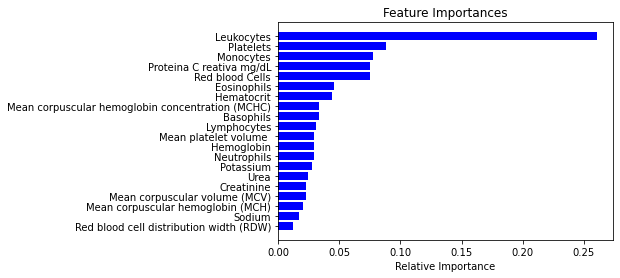

In [21]:
rf = RandomForestRegressor(max_depth=32,n_estimators=20)
rf.fit(X_train, Y_train)  
print(rf.feature_importances_)
f = plt.figure()
importances = rf.feature_importances_
indices = np.argsort(importances)
features = X_train.columns
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()
f.savefig("/tmp/yuval/Feature Importances/RF.png", bbox_inches='tight', dpi=600)

In [22]:
import shap
rf_shap_values = shap.KernelExplainer(rf.predict,X_test)

Using 122 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [23]:
rf_shap_values = rf_shap_values.shap_values( X_test)

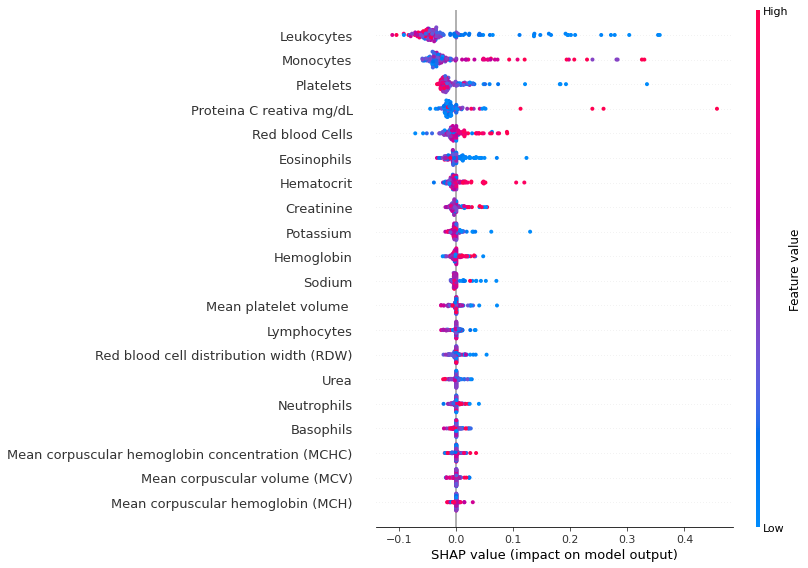

In [24]:
import matplotlib.pyplot as plt
f = plt.figure()
shap.summary_plot(rf_shap_values, X_test)
f.savefig("/tmp/yuval/RF.png", bbox_inches='tight', dpi=600)

**XGBoostClassifier**

[21:07:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0.03035057 0.04988122 0.05486546 0.02369955 0.061687   0.04340364
 0.03726095 0.11649603 0.10859244 0.03946879 0.06972976 0.04828664
 0.04267175 0.01188519 0.03429708 0.06051994 0.06228873 0.01345427
 0.03856863 0.05259241]


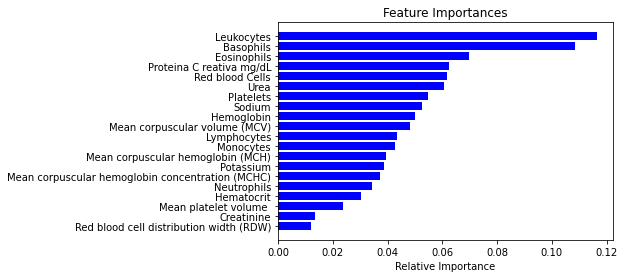

In [27]:
# xgboost
import xgboost

XGBC = xgboost.XGBRegressor(learning_rate=0.1, max_depth =32, n_estimators = 70)
XGBC.fit(X_train.values, Y_train.values)  
print(XGBC.feature_importances_)
f = plt.figure()
importances = XGBC.feature_importances_
indices = np.argsort(importances)
features = X_train.columns
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

f.savefig("/tmp/yuval/Feature Importances/xgboost.png", bbox_inches='tight', dpi=600)

In [28]:
XGBC =shap.KernelExplainer(XGBC.predict,X_test)

Using 122 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [29]:
XGBC_shap_values = XGBC.shap_values( X_test)

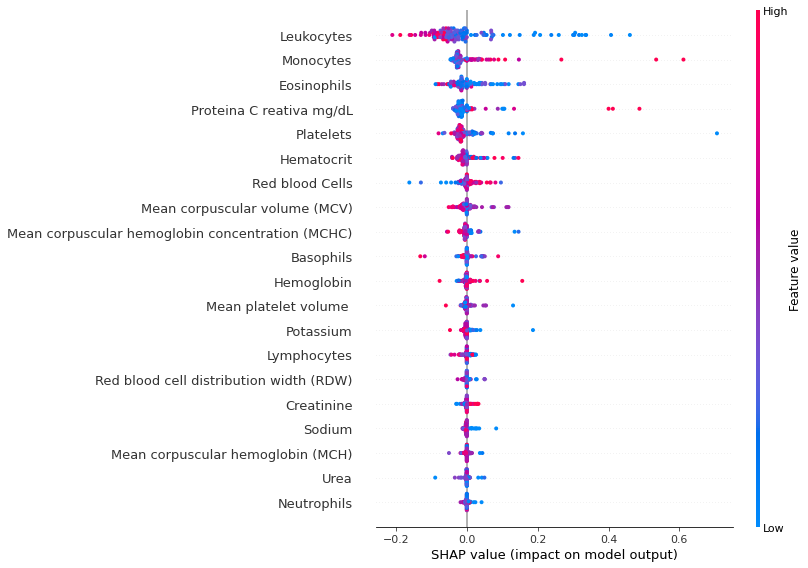

In [30]:
import matplotlib.pyplot as plt
f = plt.figure()
shap.summary_plot(XGBC_shap_values, X_test)
f.savefig("/tmp/yuval/xgboost.png", bbox_inches='tight', dpi=600)

**CatBoost**

[ 4.20690143  2.97300549  8.06226599  4.43743937  3.81881099  4.34361962
  3.10206033 20.23441531  3.56241126  3.97919479  8.50806795  4.24013106
  6.00062248  2.72125765  3.75235257  2.18938686  5.34882695  3.58194887
  3.3873615   1.54991953]


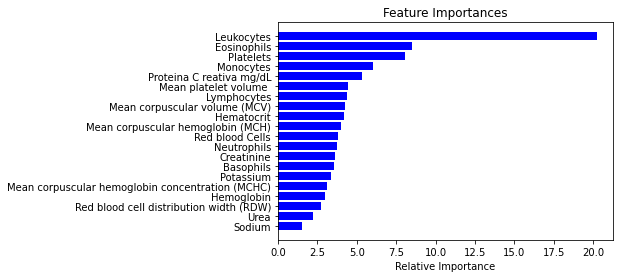

In [31]:
# Catboost 
CatBoost = CatBoostClassifier(silent=True)
CatBoost = CatBoost.fit(X_train, Y_train)  
print(CatBoost.feature_importances_)

f = plt.figure()
importances = CatBoost.feature_importances_
indices = np.argsort(importances)
features = X_train.columns
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()
f.savefig("/tmp/yuval/Feature Importances/CatBoost.png", bbox_inches='tight', dpi=600)

In [32]:
CatBoost_shap_values = shap.KernelExplainer(CatBoost.predict,X_test)

Using 122 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [33]:
CatBoost_shap_values = CatBoost_shap_values.shap_values( X_test)

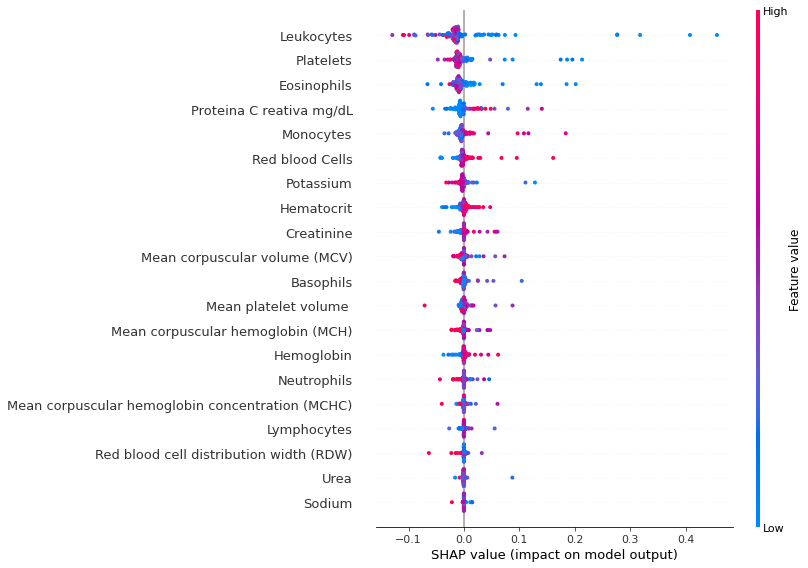

In [34]:
import matplotlib.pyplot as plt
f = plt.figure()
shap.summary_plot(CatBoost_shap_values, X_test)
f.savefig("/tmp/yuval/CatBoost.png", bbox_inches='tight', dpi=600)

**LightGBM**

[ 4.20690143  2.97300549  8.06226599  4.43743937  3.81881099  4.34361962
  3.10206033 20.23441531  3.56241126  3.97919479  8.50806795  4.24013106
  6.00062248  2.72125765  3.75235257  2.18938686  5.34882695  3.58194887
  3.3873615   1.54991953]


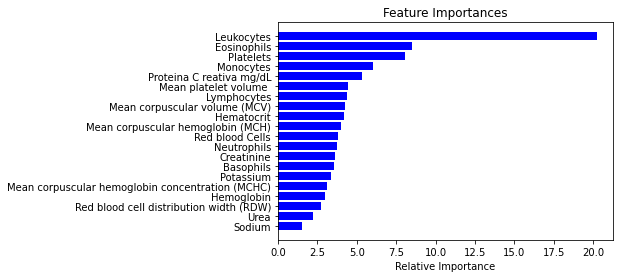

In [35]:
# LightGBM 
import lightgbm as lgb

lgbm = lgb.LGBMClassifier()
lgbm =  CatBoost.fit(X_train, Y_train)    
print(lgbm.feature_importances_)
f = plt.figure()
importances = lgbm.feature_importances_
indices = np.argsort(importances)
features = X_train.columns
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()
f.savefig("/tmp/yuval/Feature Importances/LightGBM.png", bbox_inches='tight', dpi=600)

In [36]:
lgbm_shap_values = shap.KernelExplainer(lgbm.predict,X_test)

Using 122 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [37]:
lgbm_shap_values = lgbm_shap_values.shap_values( X_test)

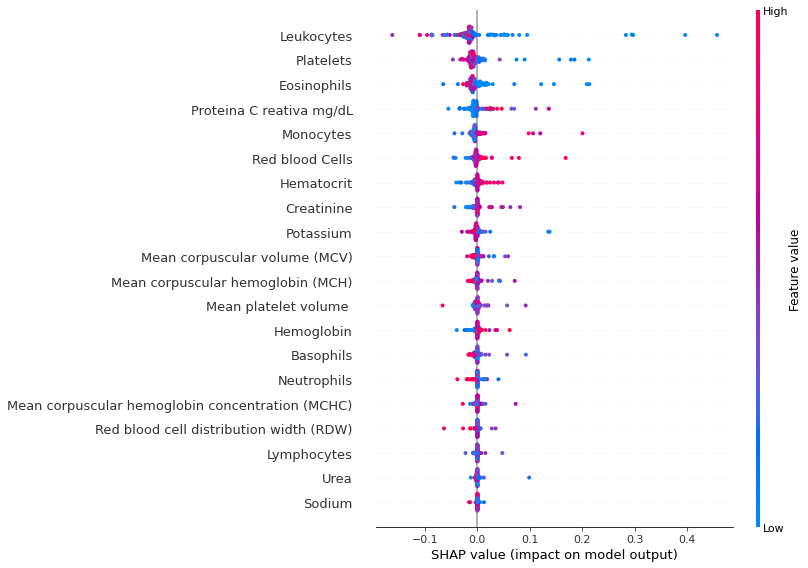

In [38]:
import matplotlib.pyplot as plt
f = plt.figure()
shap.summary_plot(lgbm_shap_values, X_test)
f.savefig("/tmp/yuval/LightGBM.png", bbox_inches='tight', dpi=600)